<h2>BMIF201 Lecture 3 in-class problem set instructions</h2>

Open lecture03_wright_fisher.py and familiarize yourself with the modifications that have been made. There are no changes that you need to make.

In [10]:
import numpy as np

class WrightFisherMigration:
    mu: float
    N: np.ndarray
    migration_rate: np.ndarray # square matrix whose (i,j) entry is the rate from j to i; defaults to the identity


    # This is the function that is called when you write: model = WrightFisherMigration(...)
    def __init__(self, mu: float, N: np.ndarray, migration_rate: np.ndarray = None):
        if migration_rate is None:
            migration_rate = np.eye(len(N))
        N = np.array(N)
        migration_rate = np.array(migration_rate)
        self.mu = mu
        self.N = N
        self.migration_rate = migration_rate
        self._check_migration_rate_is_valid()

    @property
    def number_of_populations(self) -> int:
        return len(self.N)

    def next_generation(self, allele_frequencies: np.ndarray) -> np.ndarray:
        """
        :param allele_frequencies: previous generation allele frequencies, as a number-of-populations by number-of-sites array
        :return: array of allele frequencies in the next generation
        """
        if allele_frequencies.ndim == 1:
            allele_frequencies = allele_frequencies[np.newaxis, :]

        expected_frequency = allele_frequencies.copy()  # avoid modifying input array

        # Effect of migration
        expected_frequency = self.migration_rate @ expected_frequency  # matrix multiplication

        # Effect of mutation
        expected_frequency = (expected_frequency * (1 - self.mu) +
                              (1 - expected_frequency) * self.mu)

        # Effect of drift
        result = np.zeros_like(expected_frequency)
        for i in range(self.number_of_populations):
            binomial_samples = np.random.binomial(2 * self.N[i], expected_frequency[i, :])
            result[i, :] = binomial_samples / (2 * self.N[i])

        return result

    def until_fixation(self, initial_allele_frequencies: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        :param initial_allele_frequencies: initial state
        :return: final allele frequencies (0/1-valued), time to fixation or loss
        """

        allele_frequencies = initial_allele_frequencies.copy()  # avoids modifying input array
        variants = np.where(allele_frequencies * (1-allele_frequencies) > 0)[0]  # sites not yet fixed or lost
        time_to_fixation_or_loss = np.zeros_like(allele_frequencies, dtype=int)

        generations = 0
        while len(variants) > 0:
            generations += 1
            allele_frequencies[variants] = self.next_generation(allele_frequencies[variants])
            newly_fixed_variants = (allele_frequencies[variants] * (1-allele_frequencies[variants]) == 0)
            time_to_fixation_or_loss[variants[newly_fixed_variants]] = generations
            variants = variants[~newly_fixed_variants]

        assert np.all(allele_frequencies * (1-allele_frequencies) == 0)

        return allele_frequencies, time_to_fixation_or_loss

    def _check_migration_rate_is_valid(self) -> None:
        """
        Checks that the migration rate is a square matrix of the right size with row sums equal to 1
        """
        try:
            assert self.migration_rate.shape == (self.number_of_populations, self.number_of_populations)
        except:
            raise ValueError("Migration rate matrix must be a square matrix of size equal to the number of populations")

        row_sums = np.sum(self.migration_rate, axis=1)
        if not np.allclose(row_sums, 1):
            raise ValueError("Migration rate matrix should have row sums equal to 1")

        if not np.all(self.migration_rate >= 0):
            raise ValueError("Migration rate matrix have non-negative entries")

<h5>Problem 1</h5>
Implement the function below to calculate $F_{ST}$.

In [11]:
def fixation_index(allele_frequencies_1: np.ndarray, allele_frequencies_2: np.ndarray) -> float:
    numerator = (allele_frequencies_1 - allele_frequencies_2) ** 2
    denominator = (allele_frequencies_1 + allele_frequencies_2) * (1-allele_frequencies_1 + 1-allele_frequencies_2)
    return np.mean(numerator) / np.mean(denominator)

assert np.isclose(fixation_index(np.array([0.1,0.2,0.3]), np.array([0.2, 0.1, 0.2])), 0.01694915254237288)

<h5>Problem 2</h5>

Simulate a source population at mutation-drift balance, and then simulate two populations with different $N$ diverging from it for $T$ generations, without migration. At each generation, calculate $F_{ST}$ between each pair of populations. Plot these three values of $F_{ST}$ over time. Discuss with your partner: what do you notice about the three lines? (Hint: what are their pairwise sums?)

In [12]:
num_sites = 1_000
N_source = 200
N_derived = [100, 400]
mutation_rate = 0.001
source_generations = 10 * N_source
divergence_generations = 50

source_model = WrightFisherMigration(mutation_rate, [N_source])
source_frequencies = np.ones(num_sites) / N_source
for generation in range(source_generations):
    source_frequencies = source_model.next_generation(source_frequencies)

divergence_model = WrightFisherMigration(mutation_rate, N_derived)
divergence_frequencies = np.ones((2,1)) @ source_frequencies # two identical rows
FST_source_derived_1 = np.zeros(divergence_generations)
FST_source_derived_2 = np.zeros(divergence_generations)
FST_derived_1_derived_2 = np.zeros(divergence_generations)
for generation in range(divergence_generations):
    divergence_frequencies = divergence_model.next_generation(divergence_frequencies)
    FST_source_derived_1[generation] = fixation_index(source_frequencies, divergence_frequencies[0])
    FST_source_derived_2[generation] = fixation_index(source_frequencies, divergence_frequencies[1])
    FST_derived_1_derived_2[generation] = fixation_index(divergence_frequencies[0], divergence_frequencies[1])
    

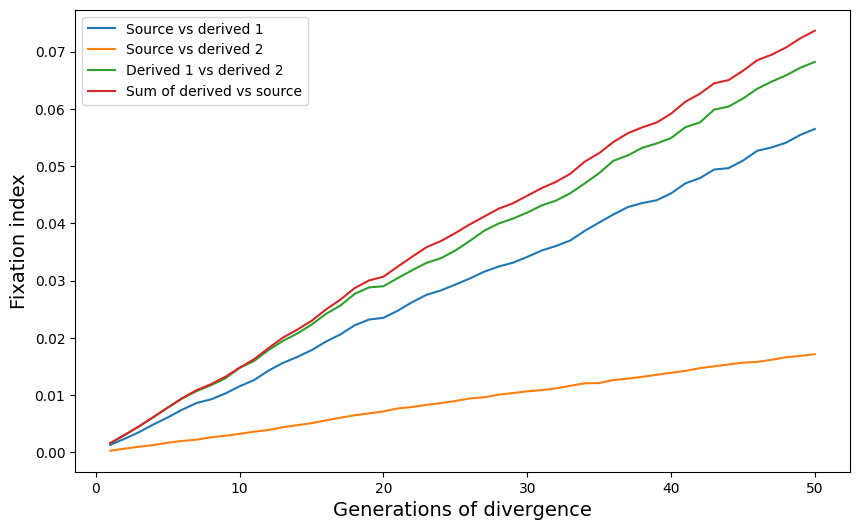

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1+divergence_generations), FST_source_derived_1)
plt.plot(range(1, 1+divergence_generations), FST_source_derived_2)
plt.plot(range(1, 1+divergence_generations), FST_derived_1_derived_2)
plt.plot(range(1, 1+divergence_generations), FST_source_derived_1 + FST_source_derived_2)

plt.xlabel('Generations of divergence', fontsize=14)
plt.ylabel('Fixation index', fontsize=14)
plt.legend(["Source vs derived 1", "Source vs derived 2", "Derived 1 vs derived 2", "Sum of derived vs source"])

plt.show()


<h5>Problem 3</h5>

Add a low rate of migration between the two derived populations, and recreate your plot. Discuss with your partner: what is different now, and why? Vary the size of each derived population; what changes, and why?

In [14]:
migration_rate = 0.1


migration_rate_matrix = np.array([[1 - migration_rate, migration_rate],[migration_rate, 1 - migration_rate]])
divergence_model = WrightFisherMigration(mutation_rate, N_derived, migration_rate = migration_rate_matrix)
divergence_frequencies = np.ones((2,1)) @ source_frequencies # two identical rows
FST_source_derived_1 = np.zeros(divergence_generations)
FST_source_derived_2 = np.zeros(divergence_generations)
FST_derived_1_derived_2 = np.zeros(divergence_generations)
for generation in range(divergence_generations):
    divergence_frequencies = divergence_model.next_generation(divergence_frequencies)
    FST_source_derived_1[generation] = fixation_index(source_frequencies, divergence_frequencies[0])
    FST_source_derived_2[generation] = fixation_index(source_frequencies, divergence_frequencies[1])
    FST_derived_1_derived_2[generation] = fixation_index(divergence_frequencies[0], divergence_frequencies[1])

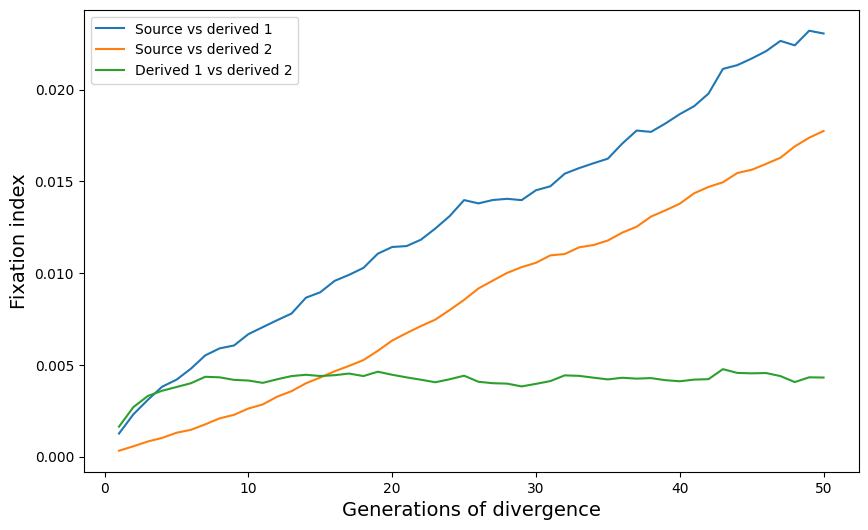

In [15]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, 1+divergence_generations), FST_source_derived_1)
plt.plot(range(1, 1+divergence_generations), FST_source_derived_2)
plt.plot(range(1, 1+divergence_generations), FST_derived_1_derived_2)

plt.xlabel('Generations of divergence', fontsize=14)
plt.ylabel('Fixation index', fontsize=14)
plt.legend(["Source vs derived 1", "Source vs derived 2", "Derived 1 vs derived 2"])

plt.show()

<h5>Optional Problem 4</h5>

Simulate 10 generations of divergence between two populations with a vector of starting allele frequencies all equal to 0.1. After 10 generations (i.e., fewer than $N$), make a histogram of $p_1-p_2$. What is its distribution? Discuss with your partner: why is this the distribution that you get? Do you expect that you will get the same distribution after $N$ generations or more?


In [16]:
starting_frequency = 0.1
num_sites = 10_000
population_size = [1000, 50]
num_generations = 10
mutation_rate = 0

model = WrightFisherMigration(mutation_rate, population_size)
frequency = starting_frequency * np.ones((2, num_sites))
for generation in range(num_generations):
    frequency = model.next_generation(frequency)

difference_in_frequency = frequency[1,] - frequency[0,]

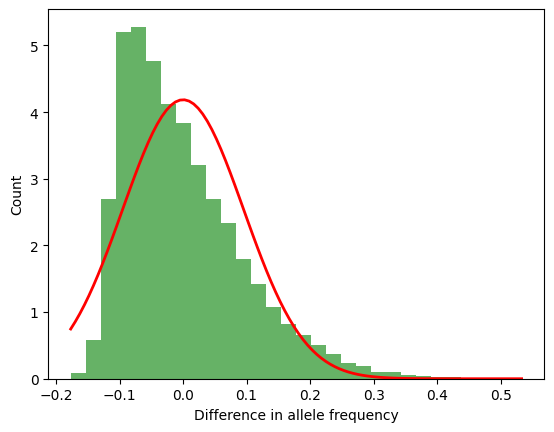

In [17]:
import scipy.stats as stats
import matplotlib.pyplot as plt

values = difference_in_frequency  # Replace with your actual data

mean = 0 
std_dev = np.sqrt(np.var(values, ddof=1))  # ddof=1 for sample variance

plt.hist(values, bins=30, density=True, alpha=0.6, color='g', label='Data')

# Overlay the normal pdf
x = np.linspace(min(values), max(values), 100)
normal_dist = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, normal_dist, 'r-', lw=2)

plt.xlabel("Difference in allele frequency")
plt.ylabel("Count")

plt.show()